<a href="https://colab.research.google.com/github/GuillermoFidalgo/QKDP/blob/master/BB84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for BB84  protocol
## Defining classes

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import os
import dataclasses
import sys

from qcrypto.simbasics import Qubit, Agent

(0.0, 1.0)

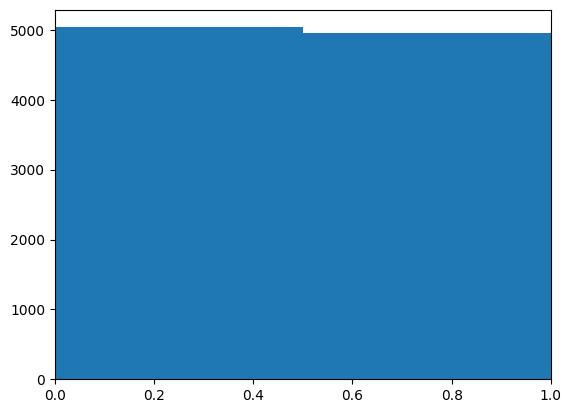

In [12]:
qubit = Qubit(0, 0, 0)
agent = Agent(base=np.pi/4)

hits = 0
rslts = []
num_msrmts = 10000 # number of measurements
for i in range(num_msrmts):
    msrmt = agent.measure(qubit)
    rslts.append(msrmt)
    if msrmt == 0:
        hits += 1

# print("Percentage of measurements which gave 0: ", hits/1000 * 100)
# print("Percentage of measurements which gave 1: ", np.abs(hits - num_trials)/1000 * 100)

plt.hist(rslts, bins=2)
plt.xlim(0,1)

## BB84 Protocol

In [ ]:
# Function for assigning Standard (s) or Hadamard (h) measurement basis
def choose_bases(stringLength=2):
    """
    Generate a random string of fixed length
    """
    basis = "sh"
    return "".join(random.choice(basis) for i in range(stringLength))


# Function for executing the BB84 protocol using n qubits and N check-bits
def BB84(numqbits, numcheckbits, eve=True, strings=False):
    """
    BB84(n,N)

    n: Length of the initial bit-string

    N: Number of bits to be used to verify the security of the key

    Eve: Default True. If True, Eve will be present in the protocol. If False, Eve will not be present.

    Stings: Default False. If True, return Alice's , Bob's and Eve's:
    1- initial bit strings
    2- keys
    3- initial basis used
    4- check bit sequence

    --------

    Returns

    R: List of strings of "OK" and "ABORT" that indicate when Eve has been detected

    a: List of Alice's bits
    b: List of Bob's bits
    e: List of Eve's bits
    x: List of Alice's key
    y: List of Bob's key
    z: List of Eve's key

    aa: List of Alice's bases assignments
    bb: List of Bob's bases assignments
    ee: List of Eve's bases assignments

    xx: List of Alice's check-bits
    yy: List of Bob's check-bits

    """

    a_bits = []
    b_bits = []
    e_bits = []
    a_key = []
    b_key = []
    e_key = []

    a_bases = choose_bases(numqbits)  # Alice's bases assignment
    b_bases = choose_bases(numqbits)  # Bob's bases assignment
    
    if eve == True:
        e_bases = choose_bases(numqbits)  # Eve's bases assignment (when present)
    else:
        e_bases = a_bases  # When Eve's not present, she can be thought of as being present,
        # but having exactly the same bit-string and same basis as Alice

    # Generate a,b,e and x,y,z
    for i in range(numqbits):
        a_bits.append(random.randint(0, 1))

        if e_bases[i] == a_bases[i]: # If Eve is not present
            e_bits.append(a_bits[i])
        else:
            e_bits.append(random.randint(0, 1)) # If Eve is present

        if b_bases[i] == e_bases[i]:
            b_bits.append(e_bits[i]) # If Eve is present, and bases are the same between Bob and Eve, just pass qbit state to Bob
        else:
            b_bits.append(random.randint(0, 1)) # If Eve is present, and bases are different between Bob and Eve, Bob's qbit is in a random state
            
        if a_bases[i] == b_bases[i]: # 
            a_key.append(a_bits[i])
            b_key.append(b_bits[i])
            e_key.append(e_bits[i])

    R = []

    for j in numcheckbits:
        if j <= len(a_key):
            s = random.sample(range(len(a_key)), j)  # Choice of check-bits
            a_checkbits = []
            b_checkbits = []
            for i in range(j):  # Generate xx,yy
                a_checkbits.append(a_key[s[i]])
                b_checkbits.append(b_key[s[i]])
            if a_checkbits != b_checkbits:  # Check for Eve's presence
                R.append("ABORT")  # Eve detected
            else:
                R.append("OK")  # Eve not detected
        else:
            break

    count = 0
    for k in range(len(a_key)):
        if e_key[k] == a_key[k] and e_key[k] == b_key[k]:
            count += 1
    #     print(count)
    guessed_bits_perc = (count / len(e_key)) * 100
    discarded_perc = 100 * (numqbits - len(a_key)) / numqbits

    if strings == False:
        return R, discarded_perc, guessed_bits_perc
    if strings == True:
        return (
            R,
            a_bits,
            b_bits,
            e_bits,
            a_bases,
            b_bases,
            e_bases,
            a_key,
            b_key,
            e_key,
            a_checkbits,
            b_checkbits,
            s, # ????
        )


# One instance of BB84 checking 2 bits for security (example)

In [ ]:
%%timeit
R,a_bits,b_bits,e_bits,a_bases,b_bases,e_bases,a_key,b_key,e_key,xx,yy,s=BB84(128,range(3),strings=True)
print("Alice's Check sequence: ",xx)
print("Bob's Check sequence:   ",yy)
print('qubits checked are # :  ',s)
print("Result of Simulation: ",R[-1])

In [ ]:
print("Alice's keys: ",a_key)
print()
print("Bobs's keys: ",b_key)
print()
print("Eve's keys: ",e_key)
print()
print("Alice's Basis: ",a_bases)
print()
print("Bobs's Basis: ",b_bases)
print()
print("Eve's Basis: ",e_bases)

# Simulation of the BB84 protocol

In [ ]:
k1=100 #Number of iterations of BB84
k2=100 # Sample points 
numqbits=128 #Number of qubits

# a=np.arange(5)# dummy variable 
# N=2**a #Number of check-bits

# In order to see the simulation with data for all values of possible checkbits uncomment the next line
numcheckbits=np.arange(1,16)

In [ ]:
dist=np.empty([k2,len(numcheckbits)]) #Probability distribution
avrg_discarded_perc=0
avrg_guessed_bits_perc=0
#Generate dist,avrg
counter=0
for j in range(k2):  #Loop for generating dist
    abort=np.zeros(len(numcheckbits),int) #Number of ABORT
    
    for i in range(k1):  #Loop for executing BB84
        R,discarded_perc,guessed_bits_perc=BB84(numqbits,numcheckbits)
#         if counter % 1000 == 0:
#             print(avrg_guessed_bits_perc)
        avrg_discarded_perc+=discarded_perc
        avrg_guessed_bits_perc+=guessed_bits_perc
        counter+=1
        for m in range(len(R)): #Loop for each N
            if R[m]=='ABORT': #Check for ABORT results
                abort[m]+=1
    pabort=abort/k1  #Experimental probability of ABORT
    dist[j]=pabort
avrg_discarded_perc=(avrg_discarded_perc)/(k1*k2)
avrg_guessed_bits_perc=avrg_guessed_bits_perc/(k1*k2)

# Calculating Percentage of Bits discarded

$$\% \text{ of discarded bits}=  \frac{1}{k_1 k_2} \sum_{i=1}^{k_1 k_2} \frac{n-\text{len}(x_i)}{n}\times 100  $$

where $n$ is the length of the initial bit-string

$k_1 k_2$ is the total number of iterations

$\text{len}(x_i)$ is the length of key prior to using the check bits on the $i$-th iteration

# Average percentage of bits that Eve guessed correctly

$$\% \text{ of bits guessed by Eve}=  \frac{1}{k_1 k_2} \sum_{i=1}^{k_1 k_2} \frac{c_i}{\text{len}(z_i)}\times 100  $$

where $c_i$ is the number of correctly guessed bits 

$\text{len}(z_i)$ is the length of Eve's key 

In [ ]:
print('average percentage of bits discarded is %.2f'%avrg_discarded_perc,'%')

In [ ]:
print('average percentage of bits that Eve guessed is %.2f'%avrg_guessed_bits_perc,'%')

In [ ]:
avrg1=np.mean(dist,axis=0) #Average of each column of dist

print(avrg1)

The average percentage of discovering Eve is the same as the probability of the key being compromised

 The list above is normalized to 1. It shows the average probability of discovering Eve when varying the amount of bits to be used to verify the security of the key.
If you just want the probability for a specific number of "check-bits" call `avrg1[#]` where `#` is any number from 0-14 (remember that python is 0-indexed) and therfore 

`avrg1[0]` = the probability of discovering Eve when **checking only 1 bit**

# Now we use Matplotlib's hist function to draw a distribution 


## Configuration of the plots

In [ ]:
#Where to store the plots
outpath='plots_BB84'

#Check if folder exists
if outpath not in os.listdir(): 
    os.mkdir(outpath)
else: 
    print(outpath,'already exists!')


#Configuration for the plots
start = 0
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=150)
    

## For one plot

In [ ]:
    
#Making 1 single plot
#Specifing qb changes the plot

qb=1
# qb is the amount of qubits to inspect UNLESS you changed the parameter lines at the simulation stage
# Keep in mind that python is 0-indexed  1 does NOT mean 1 qubit



plt.figure(num=qb,dpi=200)
count,val,_=plt.hist(dist[:,qb],bins=bins,align='left',histtype='step')
plt.vlines(x=avrg1[qb],ymin=0,ymax=max(count),label="Average Value",alpha=.63,linestyles='dashed')

plt.xticks(np.arange(start, stop+step, 2*step))
plt.legend()
plt.xlabel('Probability of discovering Eve when using %i check-bits' %numcheckbits[qb],fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xlim(0.01,1.0)
plt.title('BB84 protocol using %i qubits'%numqbits)

plt.savefig(outpath+'/'+'BB84-dist with %i check-bits.png'%numcheckbits[qb],dpi=200)
plt.show()
plt.close()

## For all plots individually

In [ ]:
for qb in range(len(numcheckbits)):
    count,val=[],[]
    plt.figure(num=qb,dpi=200)
    count,val,_=plt.hist(dist[:,qb],bins=bins,align='left',histtype='step' )
    plt.vlines(x=avrg1[qb],ymin=0,ymax=max(count),label="Average Value",linestyles="dashed",alpha=0.63)
    plt.xticks(np.arange(start, stop+step, 2*step))
    plt.xlabel('Probability of discovering Eve when using %i check-bits' %numcheckbits[qb])
    plt.ylabel('Frequency')
    plt.xlim(0.01,1.0)
    plt.title('BB84 protocol using %i qubits'%numqbits)
    plt.savefig(outpath+'/'+'BB84-dist with %i check-bits'%numcheckbits[qb],dpi=200)
    plt.show()
    plt.close()

## This part is completely optional if you want a closer look at the individual distributions

In [ ]:
for qb in range(len(numcheckbits)):
    count,val=[],[]
    plt.figure(num=qb,dpi=200)
    count,val,_=plt.hist(dist[:,qb],bins=50,align='left',histtype='step' )
    ll=['%.3f' %a for a in val]
    plt.xticks(ticks=val[::5],labels=ll[::5],fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Probability of discovering Eve when using %i check-bits' %numcheckbits[qb])
    plt.ylabel('Frequency')
    plt.title('BB84 protocol using %i qubits'%numqbits)
    plt.savefig(outpath+'/'+'CloserLook_BB84-dist with %i check-bits'%numcheckbits[qb],dpi=200)
    plt.show()
    plt.close()

## A few of them together

In [ ]:
plt.figure(dpi=200)
start = 0
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=150)

numcheckbits=np.arange(1,16)

for qb in range(0,len(numcheckbits),3):
    count,val,_=plt.hist(dist[:,qb],align='left',histtype='stepfilled',label='Probability using %i check-bits' %numcheckbits[qb],bins=bins )
    plt.vlines(x=avrg1[qb],ymin=0,ymax=max(count), colors='k', linestyles='dashed',alpha=.63)

plt.vlines(x=avrg1[0],ymin=0,ymax=.001, colors='k', linestyles='dashed',  label='Average Values',alpha=.63)
plt.xticks(np.arange(start, stop+step, 2*step),fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Probability of discovering Eve',fontsize=10)
plt.ylabel('Frequency',fontsize=12)
plt.xlim(0.05,1.0)
# plt.grid(axis='x')
plt.legend(shadow=True,fontsize=7,bbox_to_anchor=(1.015,.5), loc="center left",borderaxespad=0)
plt.title('BB84 protocol using %i qubits'%numqbits , fontsize=14)
plt.savefig(outpath+'/'+'BB84-dist-superimposed',dpi=200,bbox_inches="tight")
plt.show()
plt.close()

## Theoretical values of the probability of finding Eve

In [ ]:
N1=np.arange(1,16)
P=1-(.75)**N1
print(P)

## Errors between our theoretical values and our simulation values for the probabilities of detecting Eve

In [ ]:
# Absolute Error
abserr=np.abs(avrg1-P)

# Percentage Error
percenterr=(abserr/P)*100
print('\n    Percentage of Error       Absolute Error')
count=1
for i,a_key in zip(percenterr,abserr):
    print(str(count)+') \t'+'%.4f' %i+' %'+'\t\t %.4f' %a_key)
    count+=1


In [ ]:
plt.figure(dpi=200)
plt.bar(numcheckbits,avrg1,alpha=.5,align='edge')

plt.plot(numcheckbits,P,'--g',label='$P=1-(3/4)^N$')
plt.xticks(ticks=numcheckbits,fontsize=8)
plt.yticks(ticks=np.arange(start,stop+step,2*step),fontsize=8)
plt.xlabel('Number of Check-bits',fontsize=10)
plt.ylabel('Average Prob of Discovering Eve',fontsize=10)
plt.title('BB84 \n Probability of Discovering Eve when varying amount of check-bits', fontsize=10)
plt.legend(fontsize=10,loc='upper left',shadow=True)
plt.grid(axis='y',color='k',linestyle='--',alpha=.7)
plt.savefig(outpath+'/'+'BB84-prob-per-Check-bits.png',dpi=200)
plt.show()
plt.close()

# We also have a CSV file with data from a more precise simulation

We won't need to run a sim each time you need to look a the plots or generate other plots

We can use pandas to read the CSV file provided in the Github Repo

In [ ]:
import pandas as pd

## Configuration of the plots

In [ ]:
df=pd.read_csv('Distribution-Data-for-BB84.csv')
df

## Here we see some statistics of the simulation

In [ ]:
print(df.info())
df.describe()

In [ ]:
#Where to store the plots
outpath='pandas_plots_BB84'

#Check if folder exists
if outpath not in os.listdir():
    os.mkdir(outpath)
else: 
    print(outpath,'already exists!')


#Configuration for the plots
start = 0
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=250)
    

## Plotting all check-bit distributions in one

In [ ]:
plt.figure(dpi=200)
df.plot(kind='hist',fontsize=10, align='left',histtype='stepfilled' ,bins=bins,ax = plt.gca())
plt.legend(loc='upper center',ncol=5,fontsize=8,shadow=True)
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Probability of Detecting Eve', fontsize=12)
plt.xticks(np.arange(start, stop+step, 2*step))
plt.xlim(0.05,1.0)
plt.title('BB84 \n Probability of Detecting Eve varying the amount of checkbits',fontsize=12)
plt.savefig(outpath+'/'+'Pandas-Dist-Supermposed-All.png',dpi=200,format='png')
plt.show()
plt.close()

## Probabilities of finding Eve (average values)

In [ ]:
avrg2=df.mean()
avrg2

## Errors between our theoretical values and our simulation values for the probabilities of detecting Eve

In [ ]:
# Absolute Error
abserr=np.abs(avrg2-P)

# Percentage Error
percenterr=(abserr/P)*100
print('\n    Percentage of Error       Absolute Error')
count=1
for i,a_key in zip(percenterr,abserr):
    print(str(count)+') \t'+'%.4f' %i+' %'+'\t\t %.4f' %a_key)
    count+=1


# Final plot with the results of the simulation 

In [ ]:
N2=[0,1,3,7,14] #choosing the checkbit distributions
plt.figure(dpi=200)
for qb in N2:
    count,val,_=plt.hist(df[df.columns[qb]],align='left',histtype='bar',label='Probability using %s check-bits' %df.columns[qb],bins=bins )
    plt.vlines(x=avrg2[qb],ymin=0,ymax=max(count), colors='k', linestyles='dashed',alpha=.63)


plt.vlines(x=avrg2,ymin=0,ymax=.01, linestyles='dashed', label='Average Values')
plt.xticks(np.arange(start, stop+step, 2*step),fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Probability of Detecting Eve',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xlim(0.05,1.0)

plt.legend(loc='center left',ncol=1,shadow=True,fontsize=8,bbox_to_anchor=(1.015,.5))
plt.title('BB84\n Probability of Detecting Eve' , fontsize=12)
plt.savefig(outpath+'/'+'Pandas-BB84-dist-superimposed.png',dpi=200,bbox_inches="tight")
plt.show()
plt.close()